In [1]:
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import graphviz as gr
import numpy as np
import seaborn as sns

print(f"Running on PyMC v{pm.__version__}")
az.style.use("arviz-darkgrid")

Running on PyMC v5.0.1


The first two problems are based on the same data. The data in data(foxes)
are 116 foxes from 30 different urban groups in England. These fox groups
are like street gangs. Group size (groupsize) varies from 2 to 8 individuals.
Each group maintains its own (almost exclusive) urban territory. Some territories are larger than others. The area variable encodes this information.
Some territories also have more avgfood than others. And food influences
the weight of each fox. Assume this DAG:

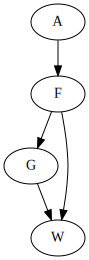

In [2]:
G = gr.Digraph()
G.edge('A', 'F')
G.edge('F', 'G')
G.edge('F', 'W')
G.edge('G', 'W', '')
G

- F is avgfood
- G is groupsize
- A is area
- W is weight

In [3]:
data = pd.read_csv('../Data/foxes.csv')
data

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85
...,...,...,...,...,...
111,29,0.67,4,2.75,4.81
112,29,0.67,4,2.75,3.94
113,30,0.41,3,1.91,3.16
114,30,0.41,3,1.91,2.78


# 1 

Use the backdoor criterion and estimate the total causal influence of A on F. 

**What effect would increasing the area of a territory have on the amount of food inside it?**

Just regress F~A

In [188]:
from sklearn.preprocessing import scale

f = scale(data['avgfood'])
a = scale(data['area'])

In [189]:
with pm.Model() as model:
    food_data = pm.ConstantData(name='Food Data', value=f)
    area_data = pm.ConstantData(name='Area Data',value=a)
    
    beta = pm.Uniform('beta',0, 1)
    alpha = pm.Uniform('alpha', 0, 1)
    sigma = pm.Uniform('sigma',0, 1)

    mu = pm.Deterministic('mu', alpha + beta*area_data)
    food = pm.Normal('avgfood', mu, sigma, observed=food_data)
    
model

   beta ~ U(0, 1)
  alpha ~ U(0, 1)
  sigma ~ U(0, 1)
     mu ~ Deterministic(f(alpha, beta))
avgfood ~ N(mu, sigma)

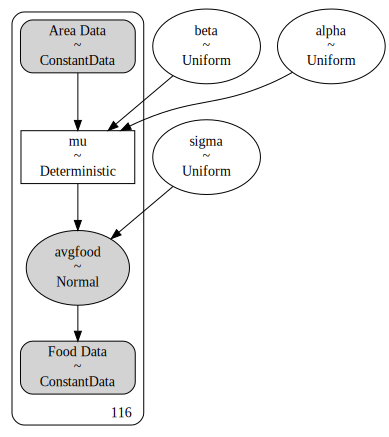

In [190]:
pm.model_to_graphviz(model)

In [191]:
with model:
    samples = pm.sample_prior_predictive(samples=1000)

Sampling: [alpha, avgfood, beta, sigma]


In [192]:
# az.extract(samples, group="prior_predictive", num_samples=100)

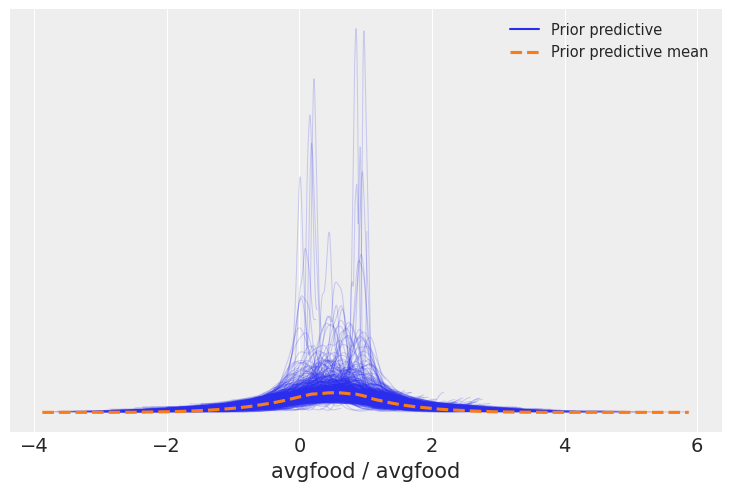

In [193]:
az.plot_ppc(samples, observed=False, group='prior');

In [194]:
with model:
    samples = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


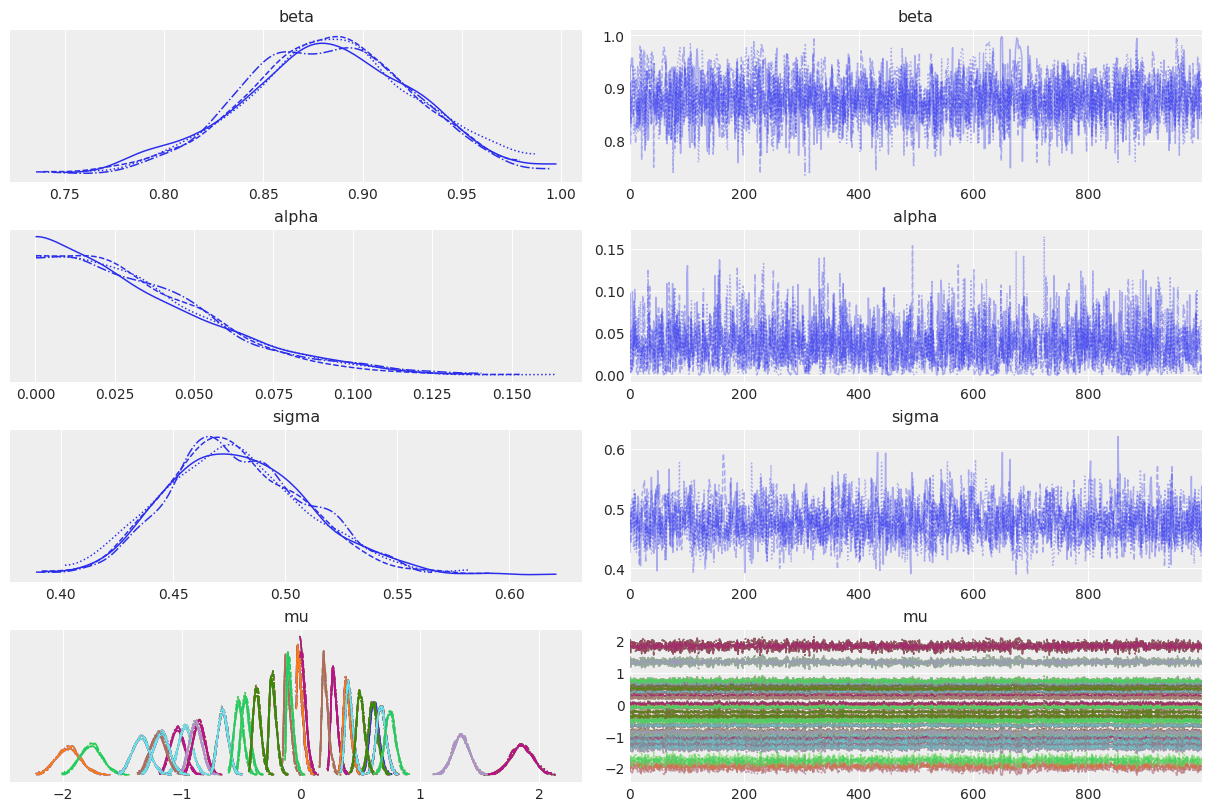

In [195]:
az.plot_trace(samples);

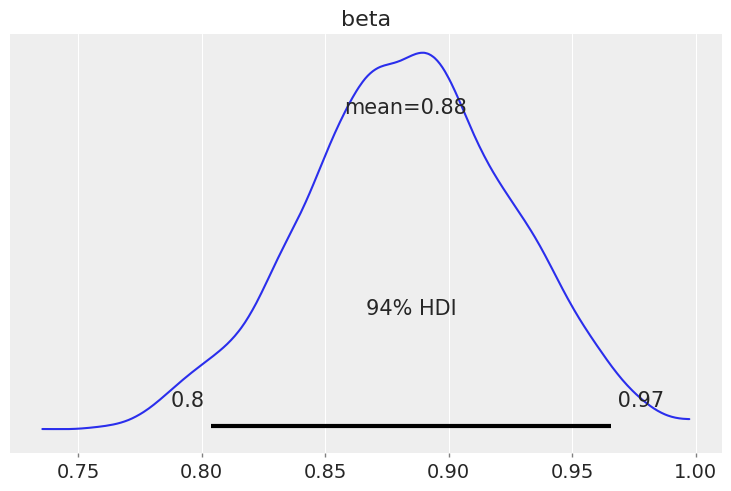

In [196]:
az.plot_posterior(samples, var_names=['beta']);

In [197]:
#Simulating lines from prior
with model:
    pm.sample_posterior_predictive(samples, extend_inferencedata=True)

Sampling: [avgfood]


<AxesSubplot: xlabel='avgfood / avgfood'>

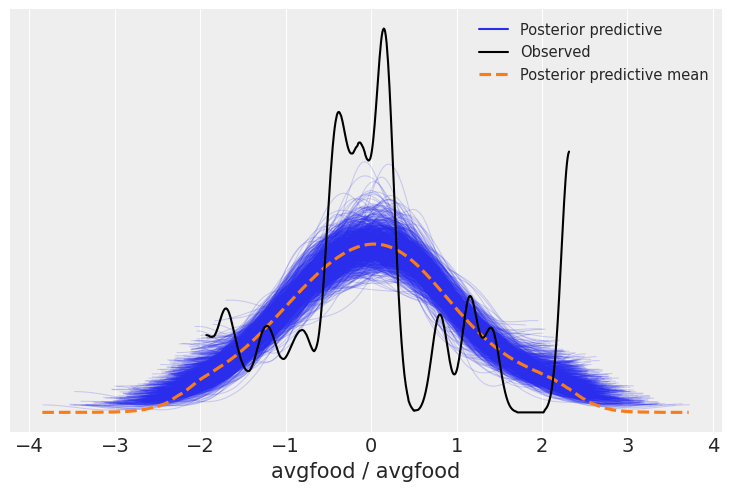

In [198]:
az.plot_ppc(samples, num_pp_samples=1000)

In [199]:
az.summary(samples, var_names=['alpha', 'beta', 'sigma'], kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,0.035,0.026,0.000,0.083
beta,0.883,0.043,0.804,0.966
sigma,0.478,0.031,0.424,0.539


# 2

Infer the total causal effect of adding food F to a territory on the weight
W of foxes. Can you calculate the causal effect by simulating an intervention
on food?

No adjustment is needed, since F causes W directly and causes G which causes W, so F~W estimation gives this.

In [140]:
from sklearn.preprocessing import scale

f = scale(data['avgfood'])
w = scale(data['weight'])

In [177]:
with pm.Model() as model:
    food_data = pm.ConstantData(name='Food Data', value=f)
    weight_data = pm.ConstantData(name='Area Data',value=w)
    
    beta = pm.Uniform('beta',0, 1)
    alpha = pm.Uniform('alpha', 0, 1)
    sigma = pm.Uniform('sigma',0, 1)

    mu = pm.Deterministic('mu', alpha + beta*food_data)
    weight = pm.Normal('weight', mu, sigma, observed=weight_data)
    
model

  beta ~ U(0, 1)
 alpha ~ U(0, 1)
 sigma ~ U(0, 1)
    mu ~ Deterministic(f(alpha, beta))
weight ~ N(mu, sigma)

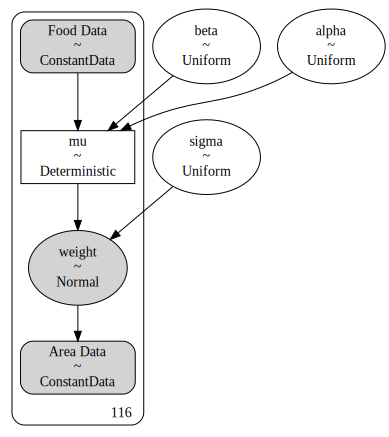

In [178]:
pm.model_to_graphviz(model)

In [179]:
with model:
    samples = pm.sample_prior_predictive(samples=1000)

Sampling: [alpha, beta, sigma, weight]


In [180]:
# az.extract(samples, group="prior_predictive", num_samples=100)

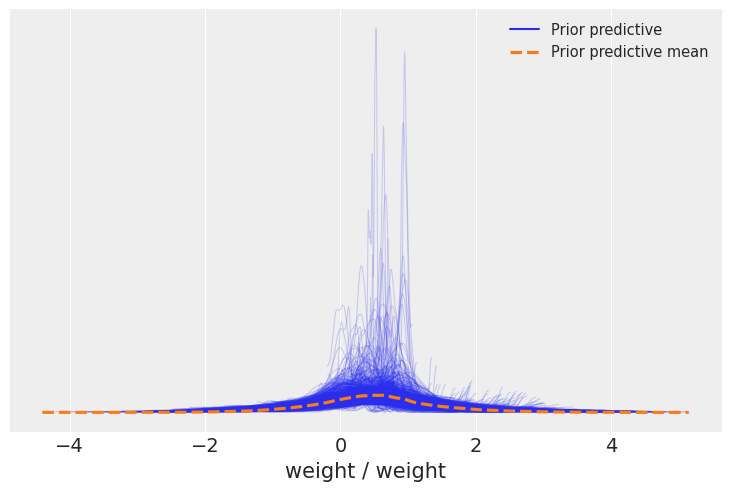

In [181]:
az.plot_ppc(samples, observed=False, group='prior');

In [182]:
with model:
    samples = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


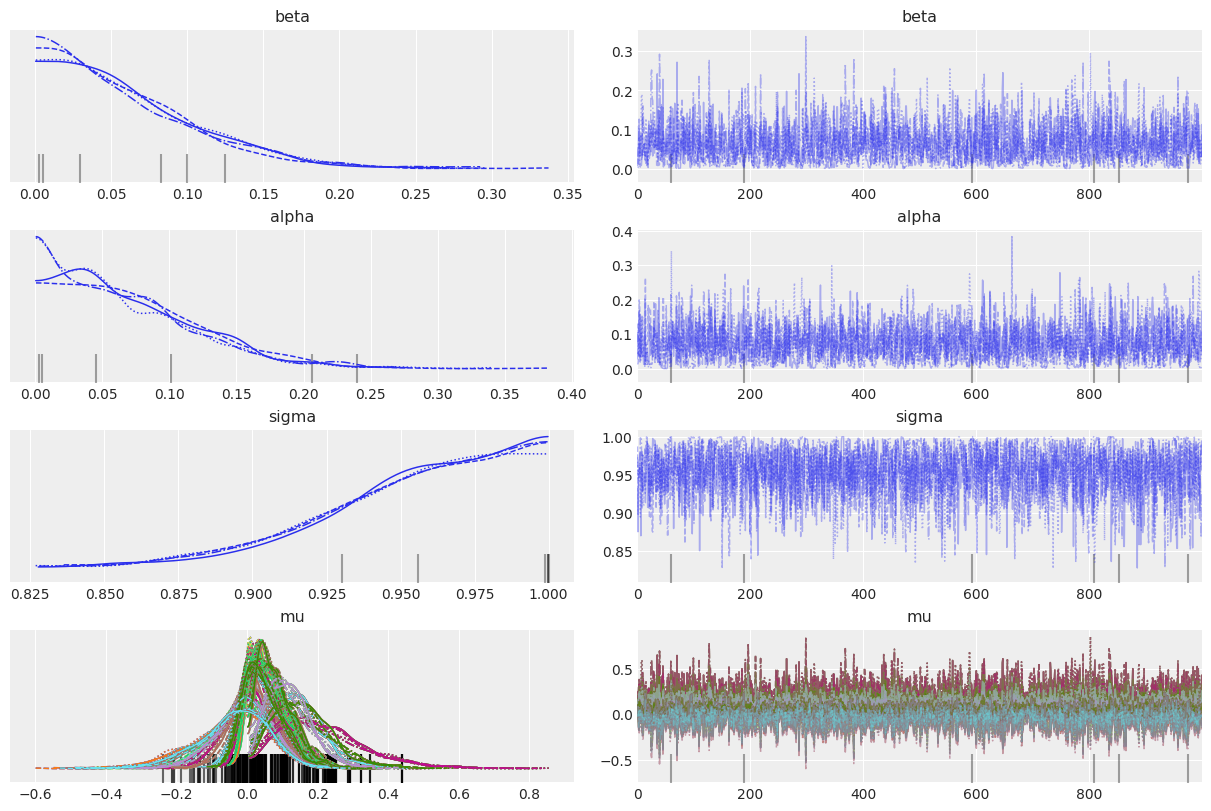

In [183]:
az.plot_trace(samples);

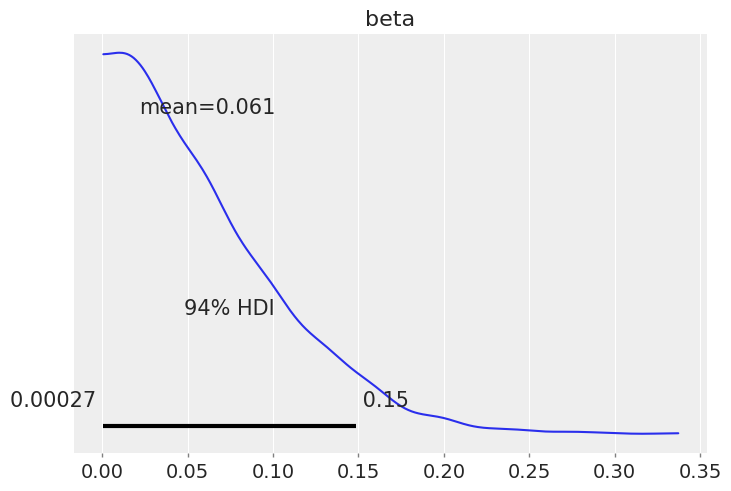

In [184]:
az.plot_posterior(samples, var_names=['beta']);

In [185]:
#Simulating lines from prior
with model:
    pm.sample_posterior_predictive(samples, extend_inferencedata=True)

Sampling: [weight]


<AxesSubplot: xlabel='weight / weight'>

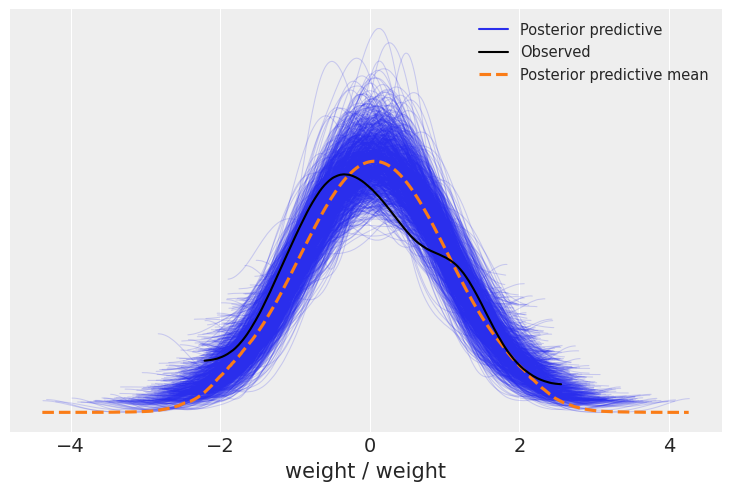

In [186]:
az.plot_ppc(samples, num_pp_samples=1000)

In [187]:
az.summary(samples, var_names=['alpha', 'beta', 'sigma'], kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,0.069,0.053,0.000,0.161
beta,0.061,0.048,0.000,0.149
sigma,0.955,0.033,0.896,1.000


# 3

Infer the direct causal effect of adding food F to a territory on the weight
W of foxes. In light of your estimates from this problem and the previous
one, what do you think is going on with these foxes?

We have do adjust for G, to block the pipe going from F->G->W

In [201]:
from sklearn.preprocessing import scale

f = scale(data['avgfood'])
w = scale(data['weight'])
g = scale(data['groupsize'])

In [214]:
with pm.Model() as model:
    food_data = pm.ConstantData(name='Food Data', value=f)
    weight_data = pm.ConstantData(name='Area Data',value=w)
    groupsize_data = pm.ConstantData(name='Groupsize Data',value=g)
    
    beta = pm.Uniform('beta',0, 3)
    alpha = pm.Uniform('alpha', 0, 3)
    sigma = pm.Uniform('sigma',0, 3)
    
    beta_g = pm.Uniform('beta_g',0, 3)

    mu = pm.Deterministic('mu', alpha + beta*food_data + beta_g*groupsize_data)
    weight = pm.Normal('weight', mu, sigma, observed=weight_data)
    
model

  beta ~ U(0, 3)
 alpha ~ U(0, 3)
 sigma ~ U(0, 3)
beta_g ~ U(0, 3)
    mu ~ Deterministic(f(beta_g, alpha, beta))
weight ~ N(mu, sigma)

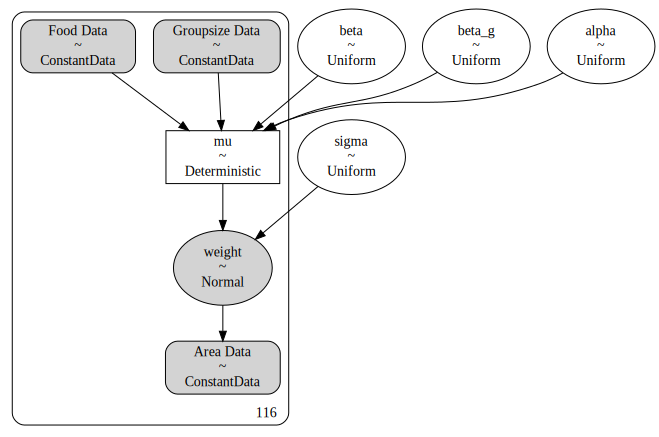

In [215]:
pm.model_to_graphviz(model)

In [216]:
with model:
    samples = pm.sample_prior_predictive(samples=1000)

Sampling: [alpha, beta, beta_g, sigma, weight]


In [217]:
# az.extract(samples, group="prior_predictive", num_samples=100)

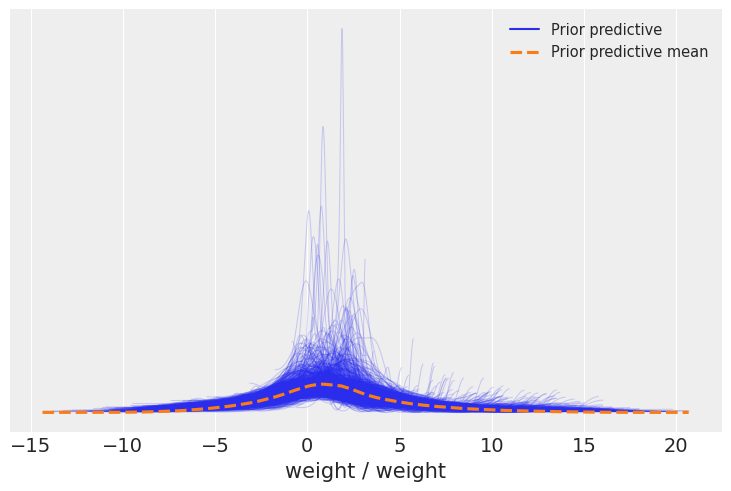

In [218]:
az.plot_ppc(samples, observed=False, group='prior');

In [219]:
with model:
    samples = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma, beta_g]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


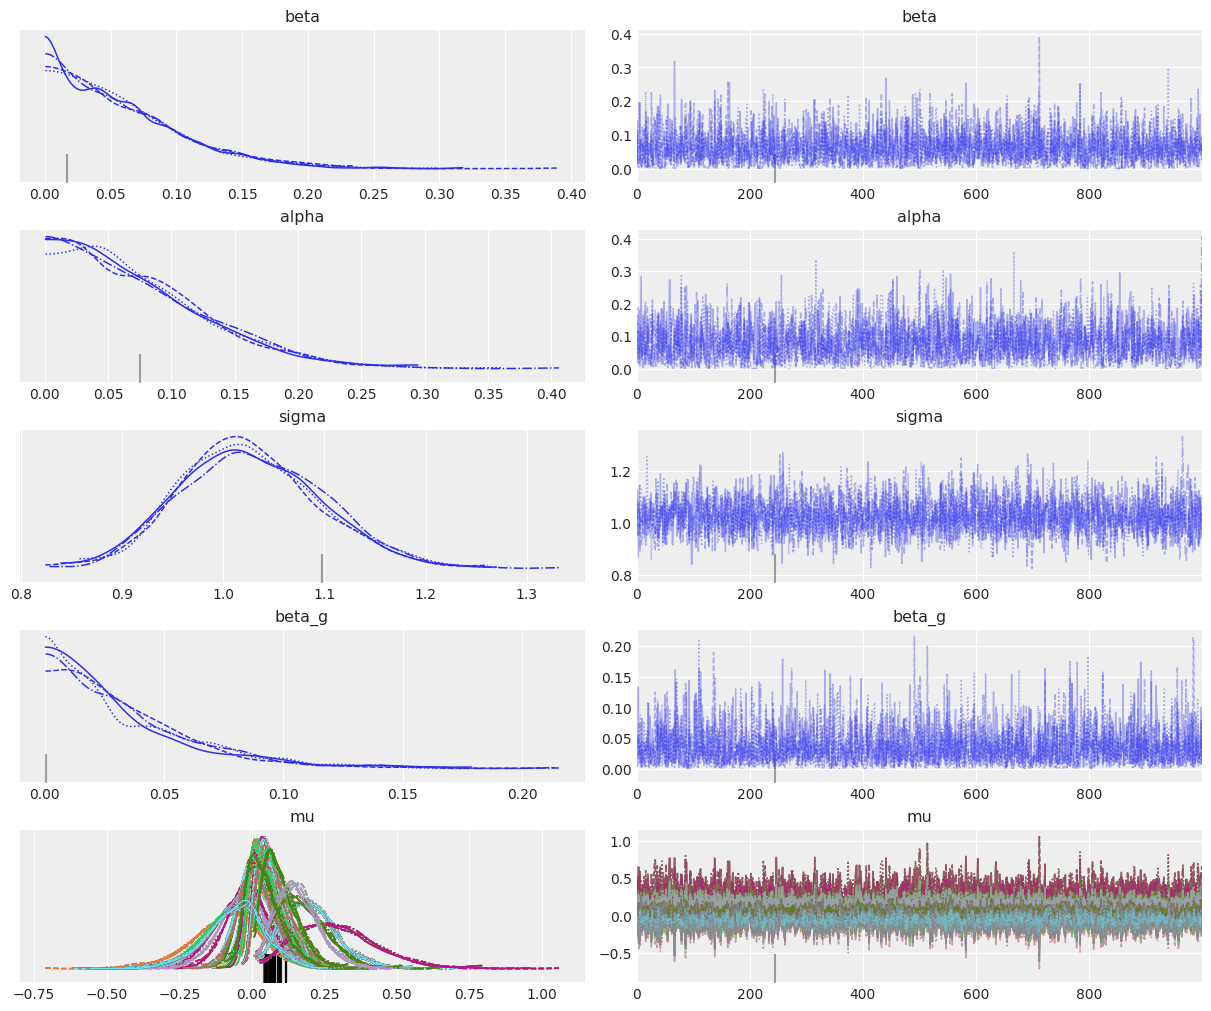

In [220]:
az.plot_trace(samples);

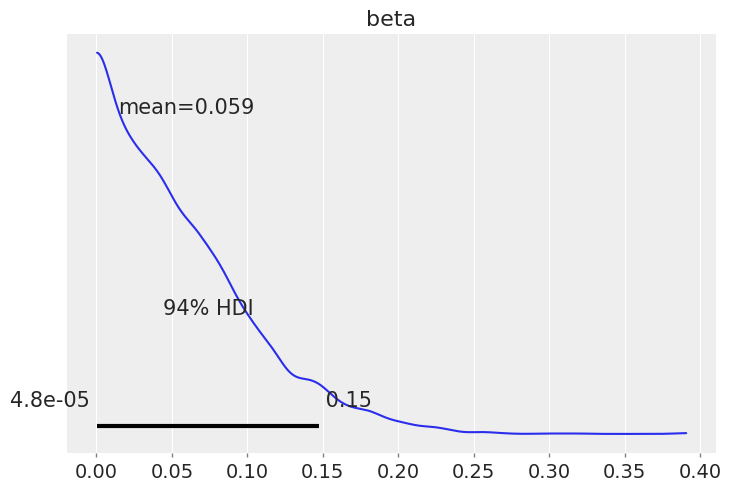

In [221]:
az.plot_posterior(samples, var_names=['beta']);

In [222]:
#Simulating lines from prior
with model:
    pm.sample_posterior_predictive(samples, extend_inferencedata=True)

Sampling: [weight]


<AxesSubplot: xlabel='weight / weight'>

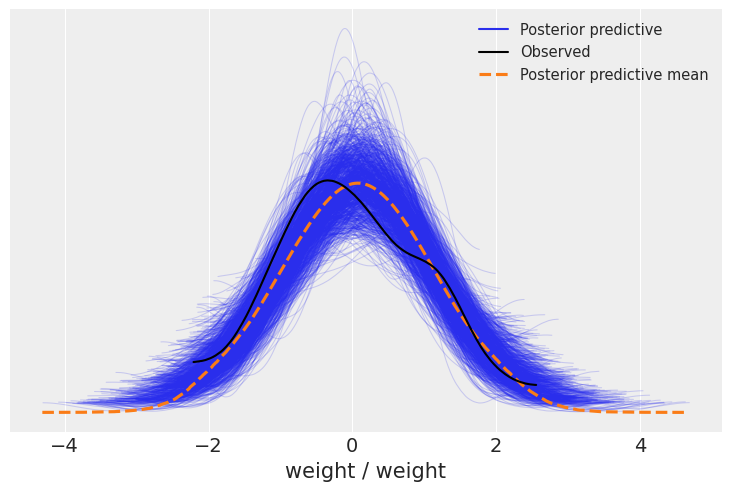

In [223]:
az.plot_ppc(samples, num_pp_samples=1000)

In [224]:
az.summary(samples, var_names=['alpha', 'beta', 'sigma'], kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,0.075,0.057,0.000,0.179
beta,0.059,0.048,0.000,0.148
sigma,1.027,0.069,0.902,1.157


# 4

Suppose there is an unobserved confound that influences F and G, like this:

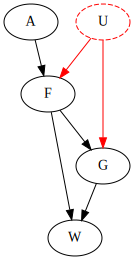

In [213]:
G = gr.Digraph()
G.edge('A', 'F')
G.edge('F', 'G')
G.edge('F', 'W')
G.edge('G', 'W')
G.edge('U', 'G', color='red')
G.edge('U', 'F', color='red')
G.node('U', color='red', style='dashed', tcolor='red')
G

Assuming the DAG above is correct, again estimate both the total and direct
causal effects of F on W. What impact does the unobserved confound have?

We should adjust for U and for G,U for the direct effect, if we don't have U is game over.